In [2]:
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os

In [23]:
REBUILD_DATA = False
class CarsVSBikes():
    IMG_SIZE = 60
    CARS = "dataset/car"
    BIKES = "dataset/bike"
    TESTING = "dataset/test"
    LABELS = {CARS: 0, BIKES: 1}
    training_data = []

    carcount = 0
    bikecount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path)#, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CARS:
                            self.carcount += 1
                        elif label == self.BIKES:
                            self.bikecount += 1

                    except Exception as e:
                        print(label, f, str(e))
                        pass
                        
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('CARS:',self.carcount)
        print('BIKES:',self.bikecount)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(60,60,3).view(-1,3,60,60)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [13]:
net = Net().to(device)

if REBUILD_DATA:
    carsvsbikes = CarsVSBikes()
    carsvsbikes.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,3, 60, 60)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


dataset/car


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 1032.64it/s]


dataset/bike


100%|██████████████████████████████████████████████████████████████████████████████| 397/397 [00:00<00:00, 1402.19it/s]
C:\Users\Kraiem Ala Eddine\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


CARS: 510
BIKES: 390
900
90
810
90


In [14]:
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 6
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,60,60)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 3, 60, 60).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))

In [30]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

import time
MODEL_NAME = f"model-{int(time.time())}"

In [36]:
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 15
    print(MODEL_NAME)
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,60,60)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                f.write(f"{MODEL_NAME},{int(time.time())},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:

In [37]:
train(net)

model-1666005428


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 39.12it/s]


In [18]:
test(net)

100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 323.65it/s]

Accuracy: 0.833


In [19]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfile
import os

# Set the geometry of tkinter frame

def open_file():
    win = Tk()
    filename = filedialog.askopenfile(mode='r', filetypes=[('images', '*')])
    if filename:
        filepath = os.path.abspath(filename.name)
        win.destroy()
        return(str(filepath))
    else:
        win.destroy()
    

In [20]:
def test_extern(net):
    path = open_file()
    img = cv2.imread(path)#, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (60, 60))
    cv2.imshow("image",img)
    if cv2.waitKey(0) == 27 :
        cv2.destroyAllWindows()
    net_out = net(torch.Tensor(img).view(-1, 60, 60).to(device))[0]
    predicted_class = torch.argmax(net_out)
    print(net_out)
    if predicted_class.item() == 0:
        print("IT's A CAR")
    else :
        print("IT's A Bike")
    

In [21]:
test_extern(net)

tensor([1., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
IT's A CAR


In [22]:
test_extern(net)

tensor([1., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
IT's A CAR


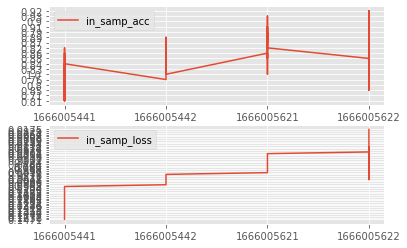

In [35]:

import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1666005428" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, sample_type, acc, loss = c.split(",")

            times.append(timestamp)
            accuracies.append(acc)
            losses.append(loss)


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="in_samp_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="in_samp_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)